In [106]:
#SETUP with Libraries and Constants

import pandas as pd
import numpy as np
import matplotlib.axes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import product
from itertools import combinations as comb

pd.options.mode.chained_assignment = None

# Cell dimensions
XCELL = 42.
ZCELL = 13.

# X coordinates translation
global_x_shifts = np.array([994.2, 947.4,-267.4,-261.5,])

# Z coordinates translations
local_z_shifts = np.array([z*ZCELL for z  in range(0,4)])
global_z_shifts = np.array([823.5, 0, 823.5, 0])

#Define Zooms for the plotting function
zooms = {0:((280, 1000), (775, 925)), 
         1:((235, 960), (-50, 100)),
         2:((-1000, -250), (775, 925)),
         3:((-1000, -250), (-50, 100)),
         4:((-1000, 1000), (-100, 1000))}

In [2]:
with open("data/Run000260/data_000000.txt", 'r+') as file:
    body = file.readlines()

column_names = ["chamber", "layer", "x_left", "x_right", "time"]
data = []

for line in body[:1000]:
    info = line.replace("\n", "").split(" ")
    hits = [info[5*i+2:5*i+7] for i in range(int(info[1]))]
    event = pd.DataFrame(hits, columns = column_names, dtype=float).astype({"chamber":"int", "layer":"int"}).drop(labels="time", axis=1)
    data.append(event)


In [3]:
def coords_conv(event: pd.DataFrame) -> pd.DataFrame:
    """
    Returns global points in the xz plane from local coordinates, where the points returned
    are in the format (x,z), always given as left_point, right_point.

    It uses global/local transformation given in the Project guide.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above. 
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    ---    
    
    Output:

    `event`: pandas.Dataframe
        the original even with added column x_global_left, x_global_right, z_global

    """

    chamber = event["chamber"]
    layer = event["layer"]-1
    x_left, x_right = event["x_left"], event["x_right"]

    x_left_prime = global_x_shifts[chamber] - x_left
    x_right_prime = global_x_shifts[chamber] - x_right

    z = global_z_shifts[chamber] + local_z_shifts[layer]

    event["x_global_left"] = x_left_prime
    event["x_global_right"] = x_right_prime
    event["z_global"] = z

    return event




def cells_conv(event: pd.DataFrame) -> np.ndarray:
    """
    Returns the cells centers given the event with several hits, one center per hit. The centers are already in global coordinates, 
    account for the alternating pattern between layers in the detector.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above. 
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    ---

    Output:

    `center_points`: numpy.ndarray, shape:(N, 2)
        An ndarray containing the center of the cells in the format [x, z]. 
        Note the shape (N, 2) in order to iterate through the different N centers.
    
    """
    centers = (event["x_left"] + event["x_right"])/2

    chamber = event["chamber"]
    layer = event["layer"] - 1

    x_centers = global_x_shifts[chamber] - centers
    z = global_z_shifts[chamber] + local_z_shifts[layer]

    center_points = np.stack([x_centers, z]).T

    return center_points


In [25]:
def event_plot(event: pd.DataFrame, ax: matplotlib.axes.Axes, detector: int = 4, zoom: bool = False) -> pd.DataFrame:
    """
    Plots the table of hits (event) on the given ax, marking the hit points and the corresponding triggered cells.
    If zoom is specified, the graph is zoomed on the corresponding detector [0->3], otherwise defaults to the larger picture.
    If an xlim is specified, it can be horizontally zoomed, otherwise the plot gets the xlim from the default constants for each detector.

    ---

    Input:

    `event`: pandas.DataFrame, format: chamber | layer | x_left | x_right
        The event (line in data.txt) given as a DataFrame. The rows represent the single hits, with format given above.
        Note that this can be used for single hits (i.e. a single row in the DataFrame).

    `ax`: matplotlib.axes.Axes
        The ax on which to plot the objects.

    `detector`: int, optional
        The detector on which to zoom on [0, 1, 2, 3]. If value is not legal, it defaults to 4.

    `xlim_manual`: tuple(int, int), optional
        Custom zoom on the x axis. Default is None.
     
    ---

    Output:

    `event_modified`: pandas.DataFrame
        Input event but with x_left, z_left and x_right, z_right added in global coordinates. Accessible with the same name 
        in the column, as in format: chamber | layer | x_left | x_right | z_left | z_right

    """
    if len(event)==0: return event

    #Use custom values for detectors zoom / xlim zoom, in case provided.
    if detector not in [0,1,2,3]: detector=4
    xlim, ylim = zooms[detector]


    #Calculate points of hit in global coordinates
    event = coords_conv(event)
    if zoom and detector !=4: 
        xlim = (event[event["chamber"]==detector]["x_global_left"].min() - 50, 
                event[event["chamber"]==detector]["x_global_right"].max() + 50)

    #Set the limits for the ax to plot the picture
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)


    #Create big gray rectangles (detectors) by taking the bottom-left corner (x-16.5*XCELL, z-ZCELL*0.5), width and height, plot them
    rects = [patches.Rectangle((x-16.5*XCELL, z-ZCELL*0.5), 
                               16.5*XCELL, 4*ZCELL, 
                               linewidth=1, edgecolor='darkgray', facecolor='none') for x,z in zip(global_x_shifts, global_z_shifts)]
    
    for rect in rects: ax.add_patch(rect)


    #Create small gray rectangles (cells)
    #For each point, find the nearest center in global coords (format: x_center, z_center, layer) and plot according to alternate pattern
    centers = cells_conv(event)
    small_rects = [patches.Rectangle((center[0]-0.5*XCELL, center[1]-0.5*ZCELL), 
                                     XCELL, ZCELL, 
                                     linewidth=1, edgecolor="darkgray", facecolor="none") for center in centers]
    for rect in small_rects: ax.add_patch(rect)


    #Plot blue-red points
    ax.plot(event["x_global_left"], event["z_global"], ".r")
    ax.plot(event["x_global_right"], event["z_global"], '.b')
    

    #Set title and labels
    if detector != 4: ax.set_title(f"Detector {detector}")
    else: ax.set_title(f"View of all detectors")
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")

    plt.plot()

    return event

In [190]:
def fits(event: pd.DataFrame, ax: matplotlib.axes.Axes, global_flag: bool = True) -> pd.DataFrame:

    if len(event)==0: return 0
    
    chambers = np.unique(event["chamber"])

    local_fits = {}

    good_local_points = []
    angles = []

    linspace = np.linspace(-1000, 1000, 10000)

    # Load every points for each layer in points, a dictionary with layers as keys.
    for chamber in chambers:

        points = {}

        # Calculate unique values for layers -> Break if there are less than 3 points on 3 different layers
        layers = np.unique(event[event["chamber"]==chamber]["layer"])
        if len(layers)<3: break

        # Load the actual points for the layer in points{}
        for layer in layers:
            event_filtered = event[(event["chamber"]==chamber) & (event["layer"]==layer)]
            left_points = np.stack([event_filtered["x_global_left"], event_filtered["z_global"]]).T
            right_points = np.stack([event_filtered["x_global_right"], event_filtered["z_global"]]).T

            concat = np.concatenate([left_points, right_points])
            
            points[layer] = concat

        # Calculate all the combinations taking one point from each layer
        stuff = [points[key] for key in points.keys()]
        combinations_list = [list(product(*substuff)) for substuff in list(comb(stuff, 3))]
        combinations = sum(combinations_list, [])
        combinations = np.array(combinations)
        
        # Calculate the first fit so that we have something to compare it to
        # IMPORTANT: Calculating with z-x and not x-z because of Vertical Square Minimizing in polyfit. This discourages vertical lines,
        # so we just swap x<->z, fit (now we get horizontal lines which are favoured), then plot again inverting x<->z again.
        best_coeffs, min_residual, _, _, _ = np.polyfit(combinations[0][:, 1], combinations[0][:, 0], 1, full=True)
        best_points = combinations[0]

        # Calculate all the local fits for every combination of points, the lowest residual is the most accurate one
        for combination in combinations:
            temp_coeffs, residual, _, _, _ = np.polyfit(combination[:, 1], combination[:, 0], 1, full=True)
            angle = np.arctan(temp_coeffs[0])
            model = np.poly1d(temp_coeffs)

            # If residual is lowered, this means better fit. We have a sign requirement on the inverse-slope as well:
            logical_conditions = residual<min_residual and angle < 0 and angle > -np.pi/4

            corresponding_x = model(global_z_shifts[chamber-1])
            spatial_conditions = corresponding_x > global_x_shifts[chamber]-16.5*XCELL and corresponding_x < global_x_shifts[chamber]

            if logical_conditions and spatial_conditions:
                min_residual = residual
                best_coeffs = temp_coeffs
                best_points = combination

        best_angle = np.arctan(best_coeffs[0])
        logical_conditions = best_angle < 0 and best_angle > -np.pi/4

        model = np.poly1d(best_coeffs)

        corresponding_x = model(global_z_shifts[chamber-1])
        spatial_conditions = corresponding_x > global_x_shifts[chamber]-16.5*XCELL and corresponding_x < global_x_shifts[chamber]

        if spatial_conditions and logical_conditions:
            best_fit = model
            local_fits[chamber] = best_fit
            angles.append(np.arctan(best_coeffs[0]))
            good_local_points.append(best_points)

    if not good_local_points: return 0
    
    try:
        angle_diff = (angles[1]-angles[0])*360/(2*np.pi)
    except:
        return 0

    MAX_ANGLE_DIFF = 10


    good_local_points = np.concatenate(good_local_points)
    global_coeffs = np.polyfit(good_local_points[:, 0], good_local_points[:, 1], 1)
    global_fit = np.poly1d(global_coeffs)


    if global_flag and angle_diff<MAX_ANGLE_DIFF and angle_diff>0 and np.sign(global_coeffs[0])==-1:
        
        for key in local_fits.keys():
            ax.plot(local_fits[key](linspace), linspace, '--c')
        ax.plot(linspace, global_fit(linspace), 'black')


    if angle_diff > MAX_ANGLE_DIFF or angle_diff < 0 : return 0

    return angle_diff
    
        


(array([33.]),
 array([0.03147639, 5.03147639]),
 <BarContainer object of 1 artists>)

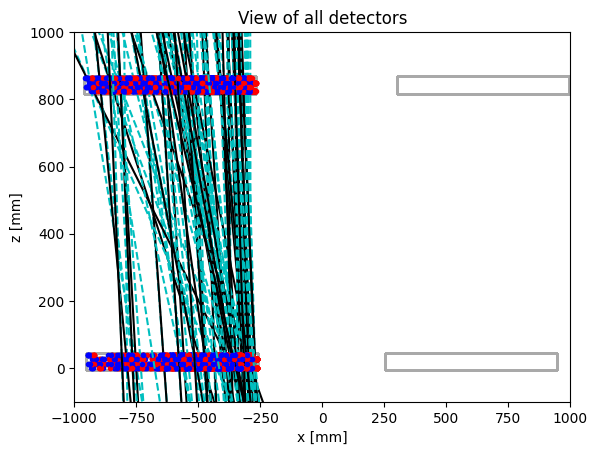

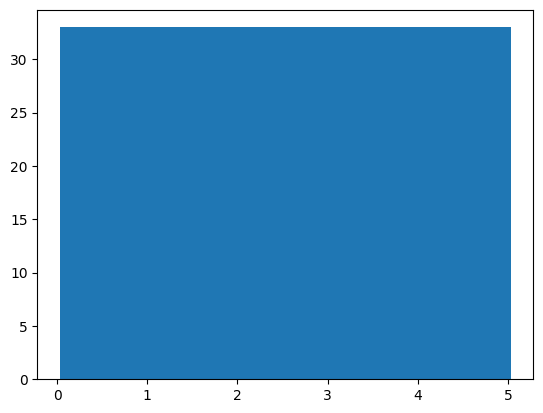

In [192]:
fig, ax = plt.subplots()
detectors_to_fit = (2,3)
data_filtered = []
angle_diffs = []

#Filter data points and get only hits from the couple (2,3) or (0,1)
for point in data:
    single = point[(point["chamber"] == detectors_to_fit[0]) | (point["chamber"] == detectors_to_fit[1])]
    data_filtered.append(single)


#Take single event from filtered ones
for event in data_filtered:
    event_modified = event_plot(event, ax, 4, zoom=True)
    angle_diff = fits(event_modified, ax, global_flag=True)
    angle_diffs.append(angle_diff)

plt.figure(2)
angle_diffs = np.array(angle_diffs)
angle_diffs_filtered = angle_diffs[angle_diffs!=0]
plt.hist(angle_diffs_filtered, bins=np.arange(start=np.min(angle_diffs_filtered), stop=np.max(angle_diffs_filtered), step=5))

In [40]:
data[16]

,chamber,layer,x_left,x_right
0,2,4,251.500,252.50
1,2,1,267.600,278.40
2,2,2,243.800,260.20
3,2,2,666.400,677.60
4,2,3,260.200,285.80
5,2,4,662.000,682.00
6,2,3,633.100,668.90
7,3,4,41.480,42.52
8,3,3,56.780,69.22
9,3,1,50.180,75.82
